# 任务目标
输入一张待处理的人像+想要编辑的属性（**性别**）信息，输出一张编辑后的人像。

# 初步建模
通过StyleGAN论文可知，在图中StyleGAN可以对一组向量（Z）进行分解，然后将分解后的风格向量（W）进行更加详细的拆分（W -> A1, A2, ...），最终经过多次上采样后生成出一张看似极其真实的人像数据。

换句话来说，就是给出一组随机的向量，然后StyleGAN就能生成出一个随机的人像数据。

## 问题
但是StyleGAN的输入是一个向量：[N, D*]，而我们的任务是`图片[N, C, H, W]`->`图片[N, C, H, W]`

**问题转化**
如果我们能从图片中


mkdir -p ～/Datasets/MNIST/MNIST/raw

cp /hy-public/MNIST/* ～/Datasets/MNIST/MNIST/raw


In [ ]:

import os
from IPython.display import display

import numpy as np
import torch
from torch import nn
from PIL import Image

from gan.reader import MNISTReader
from gan.net import GenerateNet, DiscriminatorNet, init_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 定义超参数
EPOCH = 10
BATCH_SIZE = 128

# 定义几个输出目录
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULT_PATH, exist_ok=True)

# 获取数据读取器
loader = torch.utils.data.DataLoader(
    MNISTReader(noise=True, root='~/Datasets/MNIST'),
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True)

# 新建一个生成网络和判别网络
g_net = GenerateNet()
d_net = DiscriminatorNet()

# 对两组网络做一次特殊的初始化（可以不做，效果可能会略差一点）
g_net.apply(init_weights)
d_net.apply(init_weights)
g_net.to(device)
d_net.to(device)

# 定义两组优化器，一组负责更新判别器，另一组负责更新生成器
opt_g = torch.optim.Adam(lr=0.0002, params=g_net.parameters(), betas=(0.5, 0.999))
opt_d = torch.optim.Adam(lr=0.0002, params=d_net.parameters(), betas=(0.5, 0.999))

bce = nn.BCELoss()

for epoch_id in range(EPOCH):
    for batch_id, (b_img, b_noise) in enumerate(loader):
        # Batch ID, 真实的图像, 随机Z向量[N, 100, 1, 1, 1]
        opt_d.zero_grad()
        # 先使用判别器对 真实 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_true_result = d_net(b_img.to(device))
        # 计算判断的结果距离判断为“真”的损失
        loss_true = bce(dis_true_result, torch.ones_like(dis_true_result))
        # 构建相关梯度
        loss_true.backward()

        # 使用生成网络对Z向量进行生成，[N, 100, 1, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise.to(device))
        # 使用判别器对 生成 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_fake_result = d_net(gen_img.detach())
        # 计算判断的结果距离判断为“假”的损失
        loss_fake = bce(dis_fake_result, torch.zeros_like(dis_fake_result))
        # 构建相关梯度
        loss_fake.backward()
        # 更新判别器参数
        opt_d.step()
        opt_d.zero_grad()

        opt_g.zero_grad()
        # 使用生成网络对Z向量进行生成，[N, 100, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise.to(device))
        # 使用判别器对 生成 的图像进行判断 [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 1(Sigmoid后的“概率”值)]
        dis_fake_result = d_net(gen_img)
        # 为了让生成器生成的数据更加真实，那么我们就要计算生成器生成效果与为“真”的距离
        loss_fake = bce(dis_fake_result, torch.ones_like(dis_true_result))
        # 构建相关梯度
        loss_fake.backward()
        # 更新判别器参数
        opt_g.step()
        opt_g.zero_grad()

        # 每几组数据展示一下效果
        if batch_id % 400 == 0:
            print("Acc: T",
                  (BATCH_SIZE - sum(dis_true_result.cpu().detach().numpy())) / BATCH_SIZE,
                  "F", sum(dis_fake_result.cpu().detach().numpy()) / BATCH_SIZE)
            print("Epoch_id:", epoch_id,
                  "Batch id:", batch_id,
                  "\tLoss: T ", loss_true.cpu().detach().numpy(), "F", loss_fake.cpu().detach().numpy())
            img_num = min((BATCH_SIZE, 10))
            gen_img = gen_img.cpu().detach().numpy()
            display_img = gen_img[0][0]
            for img_id in range(1, img_num):
                display_img = np.concatenate([display_img, gen_img[img_id][0]], axis=-1)
            display_img = (display_img + 1) * 127
            im = Image.fromarray(display_img).convert("RGB")
            display(im)
    torch.save(g_net.state_dict(), MODEL_PATH + f"/GEN_{epoch_id}")
    torch.save(d_net.state_dict(), MODEL_PATH + f"/DIS_{epoch_id}")


Epoch_id: 0 Batch id: 0 	Loss:  0.05223448


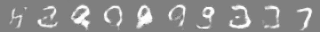

Epoch_id: 0 Batch id: 400 	Loss:  0.0061646253


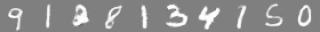

Epoch_id: 1 Batch id: 0 	Loss:  0.005590475


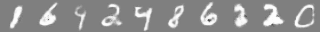

Epoch_id: 1 Batch id: 400 	Loss:  0.0052659106


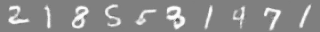

Epoch_id: 2 Batch id: 0 	Loss:  0.0050703003


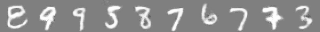

Epoch_id: 2 Batch id: 400 	Loss:  0.0043161064


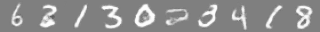

Epoch_id: 3 Batch id: 0 	Loss:  0.0042704493


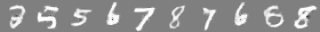

Epoch_id: 3 Batch id: 400 	Loss:  0.0038706958


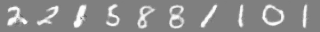

Epoch_id: 4 Batch id: 0 	Loss:  0.0038147643


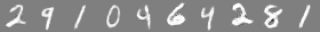

Epoch_id: 4 Batch id: 400 	Loss:  0.0035583724


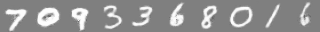

Epoch_id: 5 Batch id: 0 	Loss:  0.003803501


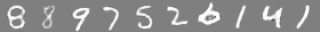

Epoch_id: 5 Batch id: 400 	Loss:  0.0033853003


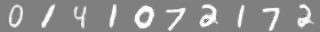

Epoch_id: 6 Batch id: 0 	Loss:  0.003759478


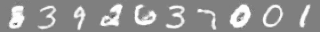

Epoch_id: 6 Batch id: 400 	Loss:  0.0033529769


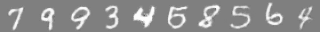

Epoch_id: 7 Batch id: 0 	Loss:  0.003370784


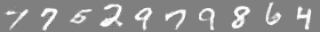

Epoch_id: 7 Batch id: 400 	Loss:  0.0033247941


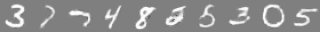

Epoch_id: 8 Batch id: 0 	Loss:  0.0033650696


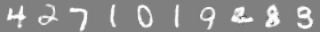

Epoch_id: 8 Batch id: 400 	Loss:  0.0033011022


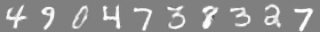

Epoch_id: 9 Batch id: 0 	Loss:  0.0030384648


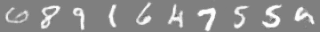

Epoch_id: 9 Batch id: 400 	Loss:  0.0031655328


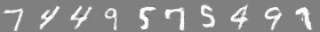

In [4]:
# Author: Acer Zhang
# Datetime:2021/10/30 
# Copyright belongs to the author.
# Please indicate the source for reprinting.

import os

import numpy as np
from PIL import Image

import torch
from torch import nn

from gan.reader import MNISTReader
from gan.net import GenerateNet, MatchingNet, init_weights

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EPOCH = 10
BATCH_SIZE = 128
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULT_PATH, exist_ok=True)

loader = torch.utils.data.DataLoader(
#     MNISTReader(noise=True), 
    MNISTReader(noise=True, root='/hy-tmp/Datasets/MNIST'), 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True)

g_net = GenerateNet()
m_net = MatchingNet()
m_net.apply(init_weights)

g_net.to(device)
m_net.to(device)

g_params = torch.load(MODEL_PATH + "/GEN_9")

opt = torch.optim.Adam(lr=0.0002, params=m_net.parameters())

sm1 = nn.SmoothL1Loss()

for epoch_id in range(EPOCH):
    for batch_id, (b_img, _) in enumerate(loader):
        # 使用Z向量生成网络，输入真实图像然后生成Z [N, 1(图像颜色通道), 32(高度), 32(宽度)] -> [N, 100, 1, 1]
        b_noise = m_net(b_img.to(device))
        # 此处可以考虑冻结相关参数，赋值法简单但影响运行效率
        g_net.load_state_dict(g_params)
        # 使用生成的Z，传入生成网络 [N, 100, 1, 1] -> [N, 1(图像颜色通道), 32(高度), 32(宽度)]
        gen_img = g_net(b_noise)

        # 缩小到16x16而非32x32，16也算是做了个平滑，可考虑使用性能更好的lpips来计算相关损失
#         loss_p2p = sm1(nn.functional.upsample(gen_img, size=[16, 16]),
#                        nn.functional.upsample(b_img, size=[16, 16]))
        loss_p2p = sm1(gen_img.to(device), b_img.to(device))
        loss_p2p.backward()
        opt.step()
        opt.zero_grad()

        if batch_id % 400 == 0:
            print("Epoch_id:", epoch_id,
                  "Batch id:", batch_id,
                  "\tLoss: ", loss_p2p.cpu().detach().numpy())
            img_num = min((BATCH_SIZE, 10))
            gen_img = gen_img.cpu().detach().numpy()
            display_img = gen_img[0][0]
            for img_id in range(1, img_num):
                display_img = np.concatenate([display_img, gen_img[img_id][0]], axis=-1)
            display_img = (display_img + 1) * 127
            im = Image.fromarray(display_img).convert("RGB")
            display(im)

    torch.save(m_net.state_dict(), MODEL_PATH + f"/M_{epoch_id}")


In [6]:

import os

import numpy as np
from PIL import Image

import torch
from torch import nn

from gan.reader import transform
from gan.net import GenerateNet, MatchingNet

INPUT_IMAGE_PATH = "src/7.jpg"
OUT_PATH = "."
MODEL_PATH = os.path.join(OUT_PATH, "model")
RESULT_PATH = os.path.join(OUT_PATH, "generate")
MAT_EPOCH = 9
GEN_EPOCH = 9

# 实例化图片生成网络和Z向量生成网络，并加载权重
g_net = GenerateNet()
m_net = MatchingNet()

m_params = torch.load(MODEL_PATH + f"/M_{MAT_EPOCH}")
g_params = torch.load(MODEL_PATH + f"/GEN_{GEN_EPOCH}")

g_net.load_state_dict(g_params)
m_net.load_state_dict(m_params)

# 打开一张数字7的图片
ori_img = Image.open(INPUT_IMAGE_PATH).convert("L")
# ori_img = np.array(ori_img)
ori_img = transform(ori_img).unsqueeze(0)
# ori_img = torch.to_tensor([ori_img.astype("float32")])

def gen(step=0):
    # 使用Z生成网络，基于数字7生成出一个Z向量，并且加入少许随机噪声，方便生成出不一样的图片
    z = m_net(ori_img) + torch.randn([100, 1, 1]) * 0.02 * step
    # 生成图片
    gen_img = g_net(z).detach().numpy()
    return gen_img[0][0]

# 绘制图片
display_img = gen()
for img_id in range(1, 10):
    display_img = np.concatenate([display_img, gen(img_id)], axis=-1)
display_img = (display_img + 1) * 127
im = Image.fromarray(display_img).convert("RGB")
display(im)
print("看，这些数字7是不一样的，我们可以在基础的7上生成相似数字的图片")

UnidentifiedImageError: cannot identify image file 'src/7.jpg'